In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install --upgrade oauth2client
!pip install -r requirements.txt

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


Requirement already up-to-date: oauth2client in /opt/conda/lib/python3.8/site-packages (4.1.3)


## (#A) Estimate Demand System

Estimate a system of demands for different kinds of food. Characterize how consumption varies with household need.

Retrieve data from google sheets using private keys:

In [2]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

#Nigeria consumption (own production) dataset
Nigeria_Data = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
exp_df = read_sheets(Nigeria_Data,sheet='Expenditures',json_creds='./students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
household_df = read_sheets(Nigeria_Data,sheet="HH Characteristics",json_creds='./students-9093fa174318.json')
household_df2 = household_df.copy()

# # Assume a single market by setting m = 1 for all
exp_df.insert(loc=2, column='m', value=1)
household_df.insert(loc=2, column='m', value=1)

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


### Data Cleaning and filter data by our chosen population (below poverty line)

In [3]:
exp_df = exp_df.replace(0,np.nan) # Replace zeroes with np.nan

#Convert all value types to float64
for i in range(3, len(exp_df.columns)):
    exp_df.iloc[:, i:] = exp_df.iloc[:, i:].astype('float64')
    
exp_df = exp_df.replace(0.0,np.nan) # Replace zeroes with np.nan

#### Create total expenditure column and filter expenditure dataframe by our condition

We create a new column 'Total expenditure' so we can filter households that have total food spendings under or at poverty line.

In [4]:
exp_df['Total expenditure'] = exp_df.iloc[:, 3:].sum(axis=1)
pd.DataFrame(exp_df['Total expenditure'])

,Total expenditure
0,20225.0
1,15365.0
2,4675.0
3,4465.0
4,7565.0
...,...
19136,31100.0
19137,6410.0
19138,20540.0
19139,22650.0


#### Poverty Line Dataframe (Households with food spendings under or equal to poverty line)

In [5]:
#87.8 thousand Naira food spending per year
#1688.46 per week
wk_poverty_line = 87800/52

poverty_line_df = exp_df[exp_df['Total expenditure'] <= wk_poverty_line]
poverty_line_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots,Total expenditure
25,2010,10028,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1210.0
56,2010,10059,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1010.0
60,2010,10063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1365.0
66,2010,10069,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,300.0,1050.0
72,2010,10075,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,100.0,NaN,NaN,60.0,NaN,NaN,NaN,1450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN,1240.0
19103,2018,379090,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,1200.0
19104,2018,379091,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400.0
19105,2018,379092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1190.0


In [6]:
#remove total expenditure column from calculation
poverty_line_df = poverty_line_df.drop(columns=['Total expenditure']) 
# poverty_line_df.set_index(['j', 't', 'm'])
poverty_line_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
25,2010,10028,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
56,2010,10059,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0
60,2010,10063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
66,2010,10069,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,300.0
72,2010,10075,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,NaN,100.0,NaN,NaN,60.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN
19103,2018,379090,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN
19104,2018,379091,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19105,2018,379092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filter household_df to include those only at or below poverty_line:

In [7]:
# filter households to those only at or below poverty line
idx_selected_households = poverty_line_df.index.tolist()
household_df = household_df[household_df.index.isin(idx_selected_households)]
household_df

,j,t,m,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
25,10028,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
56,10059,2010,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
60,10063,2010,1,0,0,0,0,3,0,1,0,0,0,0,0,0,1
66,10069,2010,1,0,0,0,0,1,0,0,0,0,1,1,3,0,1
72,10075,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,369003,2018,1,0,0,0,0,0,1,0,1,2,1,0,1,0,0
19103,369007,2018,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0
19104,369008,2018,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2
19105,369025,2018,1,0,1,0,1,0,0,2,0,0,2,0,0,1,1


#### Logged Food Expenditure Dataframe (after running np.log on values)

In [8]:
# Take logs of expenditures of our selected population and name it log_poverty_line_df
log_poverty_line_df = np.log(poverty_line_df.set_index(['j', 't', 'm']))
log_poverty_line_df

,,,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10028,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,NaN,NaN
10059,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.787492
10063,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.555348,4.605170,NaN,NaN,NaN,NaN,NaN,NaN
10069,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,NaN,5.703782
10075,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.401197,NaN,4.605170,NaN,NaN,4.094345,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379085,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.010635,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.109248,NaN,NaN,NaN
379090,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,...,NaN,NaN,NaN,5.298317,NaN,NaN,NaN,NaN,NaN,NaN
379091,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Add 'log Hsize' column to household_df:

In [9]:
# set index to j, t, m so that df.sum() ignore index values
household_df.set_index(['j','t','m'], inplace=True)

# create new column of household size
household_df['Hsize'] = household_df.sum(axis=1).values

# remove erroneous data with household_size = 0
household_df = household_df[household_df['Hsize'] > 0]

# create new column 'log Hsize'
household_df['log Hsize'] = np.log(household_df['Hsize'])

# remove Hsize column
household_df = household_df.drop(columns=['Hsize']) 

#### Household Characteristic Table (Only includes households at/below poverty line)

In [10]:
household_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,log Hsize
j,t,m,,,,,,,,,,,,,,,
10028,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000
10059,2010,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.000000
10063,2010,1,0,0,0,0,3,0,1,0,0,0,0,0,0,1,1.609438
10069,2010,1,0,0,0,0,1,0,0,0,0,1,1,3,0,1,1.945910
10075,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369003,2018,1,0,0,0,0,0,1,0,1,2,1,0,1,0,0,1.791759
369007,2018,1,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1.609438
369008,2018,1,0,0,1,0,0,0,1,0,0,0,0,0,0,2,1.386294


### Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [11]:
import cfe

#regressand y is food expenditures (np.logged) by our selected population
#regressor z is household demographics

result = cfe.Result(y=log_poverty_line_df,z=household_df, min_xproducts=15, min_proportion_items=0.05)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [12]:
result

<xarray.Result>
Dimensions:           (i: 19, j: 3914, k: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) int64 10002 10003 10004 10008 ... 379063 379066 379091
  * m                 (m) int64 1
  * t                 (t) int64 2010 2012 2015 2018
  * i                 (i) <U36 'Beef' 'Bread' ... 'White beans' 'Yam-roots'
  * k                 (k) <U9 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 51+' 'log Hsize'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 nan 0.0 nan nan ... nan nan nan nan
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 nan 0.0 nan nan ... nan nan nan nan
Attributes:
    firstround:            2010
    min_proportion_items:  0.05
    min_xproducts:         15
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

In [13]:
# result.get_loglambdas(as_df=True).quantile(0.8)

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [14]:
result.get_reduced_form()

/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:367: UserWarning: No variation in: (2018, 1)
  warnings.warn("No variation in: %s" % str(constant))


After running this we can examine the estimated coefficients $\delta$:



In [15]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                        F 0-3   F 14-18   F 19-30   F 31-50   
i                                                                              
Beef                                 -0.340643  0.703721  0.455633  0.282683   
Bread                                -0.210497  0.384956  0.137789  0.154102   
Chocolate drinks                     -0.020837 -0.210955 -0.006715  0.778218   
Condiments,(salt,spices,pepper, etc) -0.081448  0.098230 -0.196725 -0.108160   
Fish-Dried                           -0.251371 -0.064578  0.531575  0.355600   
Fish-Frozen                           0.071148 -0.116040 -0.050907 -0.049176   
Fish-Smoked                          -0.297986  0.460555  0.020186 -0.059806   
Gari-White                           -0.014989 -0.296744 -0.667894 -0.305155   
Okra-fresh                            0.187255 -0.150628  0.098796  0.249065   
Onions                                0.063635  0.032728  0.052107  0.003684   
Other vegetables (fresh or canned)   -0.138874 -0.215138 -0.570664 -0.391069   
Palm oil                             -0.036687 -0.126573 -0.062274  0.039690   
Rice-local                            0.054394  0.002751 -0.097133  0.112600   
Sachet water                         -0.375114 -0.256138  0.319351  0.073217   
Sugar                                -0.116719 -0.154616 -0.179956 -0.022552   
Tomato puree(canned)                  0.028332  0.141080  0.289563  0.185265   
Tomatoes                             -0.023064 -0.051245  0.021985  0.034755   
White beans                          -0.009318 -0.045006 -0.159407 -0.107420   
Yam-roots                             1.378769 -0.708661 -0.443326  0.118852   

                                                                              \
k                                        F 4-8     F 51+    F 9-13     M 0-3   
i                                                                              
Beef                                  0.143120  0.241615  0.182935  0.564094   
Bread                                 0.101895  0.047160 -0.003059  0.042736   
Chocolate drinks                     -0.228102  0.328883  0.402886  0.810428   
Condiments,(salt,spices,pepper, etc) -0.016007 -0.109443 -0.064455 -0.267520   
Fish-Dried                           -0.089037  0.070636  0.210752 -0.205196   
Fish-Frozen                           0.163189 -0.222139 -0.200860 -0.146800   
Fish-Smoked                           0.116955 -0.179441 -0.098302 -0.109822   
Gari-White                            0.120559 -0.340970 -0.318731  0.251451   
Okra-fresh                           -0.096679  0.234145  0.088487  0.026267   
Onions                               -0.034866 -0.097964  0.013738 -0.062612   
Other vegetables (fresh or canned)   -0.145253 -0.215343  0.358391 -0.247002   
Palm oil                              0.026048 -0.104444 -0.046923  0.013721   
Rice-local                           -0.173019 -0.012385 -0.035817 -0.186126   
Sachet water                         -0.262337 -0.204147 -0.019526  0.694609   
Sugar                                 0.035337 -0.221757  0.151570  0.114557   
Tomato puree(canned)                  0.144903  0.267296  0.429025  0.230505   
Tomatoes                             -0.014163  0.010144  0.007543 -0.213386   
White beans                          -0.067176 -0.149043 -0.090446 -0.054331   
Yam-roots                             0.607442 -0.061581 -0.389460 -0.198604   

                                                                              \
k                                      M 14-18   M 19-30   M 31-50     M 4-8   
i                                                                              
Beef                                 -0.046537  0.013506  0.303132  0.035341   
Bread                                -0.029864  0.091314  0.266542  0.023953   
Chocolate drinks                     -0.203486  0.902648  0.442241  0.513564   
Condiments,(salt,spices,pepper, etc) -0

Also the good-time constants $a_{it}$ (this captures the effects of prices)<br>
i.e. differences in year and alpha coefficient


In [16]:
result.a.to_dataframe().unstack('i')

a                             \
i           Beef     Bread Chocolate drinks   
t    m                                        
2010 1  5.436883  4.574236         3.526989   
2012 1  5.448763  4.481861         3.580424   
2015 1  5.874671  4.848463         3.527464   
2018 1  5.525306  4.626533         4.047874   

                                                                    \
i      Condiments,(salt,spices,pepper, etc) Fish-Dried Fish-Frozen   
t    m                                                               
2010 1                             3.183395   5.205244    5.476077   
2012 1                             3.549140   5.761864    5.664075   
2015 1                             3.703422   5.532878    5.796248   
2018 1                             3.998622   5.398635    5.578782   

                                                    \
i      Fish-Smoked Gari-White Okra-fresh    Onions   
t    m                                               
2010 1    5.095409   4.982314   3.508961  3.628677   
2012 1    5.256019   4.928513   3.651264  3.451501   
2015 1    5.912098   4.996242   3.804744  3.748305   
2018 1    5.305017   4.803767   4.024519  4.005598   

                                                                             \
i      Other vegetables (fresh or canned)  Palm oil Rice-local Sachet water   
t    m                                                                        
2010 1                           4.221337  4.919701   4.799363     3.772153   
2012 1                           4.056230  4.845878   4.873256     3.607586   
2015 1                           4.176310  4.967249   5.084184     4.201708   
2018 1                                NaN  5.058284   5.042315     3.352278   

                                                                       
i          Sugar Tomato puree(canned)  Tomatoes White beans Yam-roots  
t    m                                                                 
2010 1  3.558670             3.553614  3.998526    4.628326  5.266021  
2012 1  3.677386             3.772025  4.158887    4.953447  5.380372  
2015 1  3.774717             4.085687  4.327048    4.871236  6.552468  
2018 1  3.509220             3.918328  4.208182    5.161244  5.558241

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [17]:
result.get_beta(as_df=True)

i
Beef                                         NaN
Bread                                   0.184630
Chocolate drinks                             NaN
Condiments,(salt,spices,pepper, etc)    0.838028
Fish-Dried                                   NaN
Fish-Frozen                             0.358618
Fish-Smoked                             0.164329
Gari-White                                   NaN
Okra-fresh                              0.349810
Onions                                  0.442488
Other vegetables (fresh or canned)           NaN
Palm oil                                0.235511
Rice-local                              0.035017
Sachet water                                 NaN
Sugar                                   0.739102
Tomato puree(canned)                    0.090500
Tomatoes                                0.224712
White beans                             0.209857
Yam-roots                                    NaN
Name: beta, dtype: float64

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


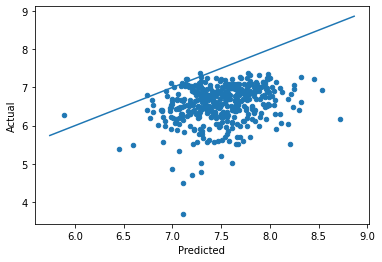

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

## (B) Nutritional content of different foods

For all the foods you're considering you'll need to be able to describe their nutritional content, in terms that allow you to compare with recommended daily allowances.

#### Load in Nigeria Consumption dataframe:

In [19]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

url = '1kG_fVBmj9EEF9LOwxN30HBxkQENOoWeQjVPYzMJe3b4'

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
consumption_df = read_sheets(key=url ,sheet='Consumption',json_creds='./students-9093fa174318.json')

# Consider consumption of only those in our selected households
consumption_df.insert(loc=2, column='m', value=1)

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


In [20]:
selected_household_ids = exp_df.index.tolist()
selected_household_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [21]:
consumption_df.set_index(['j','t','m'])
consumption_df = consumption_df[consumption_df.index.isin(selected_household_ids)]
consumption_df

,t,j,m,u,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
0,2010,10001,1,Kilograms,NaN,0.89,NaN,NaN,NaN,NaN,...,1.5,NaN,0.42,1.0,NaN,NaN,3.0,NaN,NaN,16.0
1,2010,10001,1,Litres,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,10002,1,Kilograms,NaN,0.89,NaN,NaN,NaN,NaN,...,1.8,0.12,0.56,1.0,NaN,NaN,2.0,NaN,NaN,13.8
3,2010,10002,1,Litres,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,10003,1,Kilograms,NaN,0.44,NaN,NaN,NaN,NaN,...,1.4,0.30,0.21,1.0,NaN,NaN,0.6,NaN,NaN,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19136,2012,190123,1,kilogram (kg),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0
19137,2012,190124,1,centilitre (cl),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19138,2012,190124,1,grams (g),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19139,2012,190124,1,kilogram (kg),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Loading in fdc_codes from google sheets:

In [22]:
# File with private keys for relevant service account to authenticate
# and access google spreadsheets
!gpg --batch --passphrase "casimir" -d project3-key.json.gpg > project3-key.json

serviceacct = {'project2-casimir-funk':'project3-key.json'}
sheet_url = "https://docs.google.com/spreadsheets/d/1O0nHroRtnzBKSZXVWlqdTLIX16n5gg8aVBPcTjvLFKo/edit#gid=0"
sheet_name = 'Codes'

# Add credentials if sheet not meant to be public
fdc_code_df = read_sheets(key=sheet_url, json_creds=serviceacct["project2-casimir-funk"], sheet=sheet_name)
fdc_code_df

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


,Food description,USDA FDC ID,Kilograms/Litres
0,Pawpaw,1687869,0.1
1,Sheabutter,474641,0.1
2,Watermelon,1620656,0.1
3,Biscuits,477478,0.1
4,Buns/PofPof/Donuts,444979,0.1
...,...,...,...
127,Beer (local and imported),1104393,0.1
128,Palm wine,173185,0.1
129,Pito,1104393,0.1
130,Gin,1104487,0.1


In [23]:
#list of foods consumed:
fdc_food_items = fdc_code_df['Food description'].tolist()
fdc_food_items

['Pawpaw',
 'Sheabutter',
 'Watermelon',
 'Biscuits',
 'Buns/PofPof/Donuts',
 'Cake',
 'Cashew nut',
 'Cassava-Roots',
 'Cheese (wara)',
 'Ogbonno grinded',
 'Ogbonno ungrinded',
 'Meat pie/Sausage roll',
 'Guava',
 'Kola nut',
 'Coconut',
 'Coconut oil',
 'Dry pepper',
 'Fruit juice canned',
 'Grinded pepper',
 'Apples',
 'Groundnuts (shelled)',
 'Groundnuts (unshelled)',
 'Fresh pepper',
 'Maize (off the cob/grains)',
 'Maize (on the cob)',
 'Maize (shelled/off the cob)',
 'Maize (shelled/on the cob)',
 'Maize (unshelled/on the cob)',
 'Maize shelled',
 'Melon (ground)',
 'Chocolate drinks',
 'Guinea Corn/Sorghum',
 'Millet',
 'Maize',
 'Rice-local',
 'Rice-Imported',
 'Bread',
 'Maize flour',
 'Yam flour',
 'Cassava flour',
 'Wheat flour',
 'Other grains and flour',
 'Cassava-roots',
 'Yam-roots',
 'Gari-White',
 'Gari -Yellow',
 'Cocoyam',
 'Plantains',
 'Sweet Potatoes',
 'Potatoes',
 'Other roots and tuber',
 'Soya beans',
 'Brown beans',
 'White beans',
 'Groundnuts',
 'Other nu

In [24]:
#example: accessing fdc code from the dataframe
f = fdc_food_items[29]
fdc_id = int(fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0])
fdc_id

746770

In [25]:
import fooddatacentral as fdc

# API key for FDC
apikey = "V0mOAdVrSineT4d2VTMTJUNPAsBTnjzUAU6e6H6V" # inIyO1begWSRqsYtxS7m6p09PSyq7Qiw7fxzV2qN"


# Query to fdc and get dataframe containing nutritional data of foods using their fdc_ids
food_to_nutrients = {}
for f in fdc_food_items:
    fdc_id = fdc_code_df[fdc_code_df['Food description'] == f]['USDA FDC ID'].values[0]
    if not np.isnan(fdc_id):
        try:
            fdc_id = int(fdc_id)
            food_to_nutrients[f] = fdc.nutrients(apikey, fdc_id).Quantity
        except AttributeError:
            print(fdc_id)
            pass
#             warnings.warn("Couldn't find FDC Code %s for food %s." % (f, fdc_id))

nutritional_df = pd.DataFrame(food_to_nutrients,dtype=float).fillna(0.0)
nutritional_df

,Pawpaw,Sheabutter,Watermelon,Biscuits,Buns/PofPof/Donuts,Cake,Cashew nut,Cassava-Roots,Cheese (wara),Ogbonno grinded,...,Malt drinks,"Soft drinks (Coca cola, spirit etc)",Fruit juice canned/Pack,Other Non-acoholic drinks,Other non-acoholic drinks,Beer (local and imported),Palm wine,Pito,Gin,Other alcoholic beverages
10:0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
11:0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
12:0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.001,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
13:0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
14:0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.013,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Menaquinone-4),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
Vitamin K (phylloquinone),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.900,0.0,4.200,...,0.00,0.00,2.30,0.0,0.0,0.00,0.00,0.00,0.00,0.0
Vitamins and Other Components,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0
Water,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.680,0.0,83.460,...,91.00,89.36,86.71,0.0,0.0,91.96,86.58,91.96,66.60,66.6


## (B) Nutritional adequacy of diet

Given the food actually consumed in your data, what can you say about the adequacy of the diets in the population you're studying? What proportion of households consume enough so that members will exceed dietary recommendations? What proportion do not?

In [26]:
bmin = pd.read_csv('./diet_minimums.csv').set_index('Nutrition').iloc[:,2:]
bmax = pd.read_csv('./diet_maximums.csv').set_index('Nutrition').iloc[:,2:]
dri_df = pd.concat([bmin,-bmax])
dri_df

,C 1-3,F 4-8,M 4-8,F 9-13,M 9-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
Nutrition,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
"Fiber, total dietary",14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
"Folate, DFE",150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
"Calcium, Ca",700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
"Carbohydrate, by difference",130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
"Iron, Fe",7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
"Magnesium, Mg",80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


### Data Cleaning: Convert consumption values to hectograms

#### Function to get the nutritional content of a certain food:

In [27]:
def get_nutri(food_name):
    return nutritional_df[food_name]

In [28]:
all_consumed_foods = consumption_df.columns[4:]
food_name = all_consumed_foods[1]
food_name

'Agricultural eggs'

In [29]:
get_nutri(food_name)

10:0                              0.0
11:0                              0.0
12:0                              0.0
13:0                              0.0
14:0                              0.0
                                 ... 
Vitamin K (Menaquinone-4)         0.0
Vitamin K (phylloquinone)         0.0
Vitamins and Other Components     0.0
Water                            86.3
Zinc, Zn                          0.0
Name: Agricultural eggs, Length: 173, dtype: float64

#### Function to calculate total nutritional content consumed of a selected household:

In [30]:
# household_idx = list of households
consumption_df = consumption_df.set_index(['t', 'j', 'm'])
household_idx = consumption_df.index

In [112]:
# select a random household idx
h1_idx = household_idx[1500]
h1_idx

(2010, 40196, 1)

In [113]:
def get_h_consumption_df(idx):
    # access consumption_df and get household info
    h_con = consumption_df.loc[idx]
    h_con = h_con.fillna(0)
    
    #set index to food unit
    h_con = h_con.set_index('u')
    
    #remove 0 values i.e. food not eaten by household
    h_con = h_con.loc[:, h_con.sum(axis=0) != 0.0]
    
    return h_con

In [114]:
h1_df = get_h_consumption_df(h1_idx)

In [115]:
def get_unit(df, food):
    unit_idx = df[food].to_numpy().nonzero()[0][0]
    return df.index[unit_idx]

In [116]:
food = h1_df.columns[0]
get_unit(h1_df, food)

'Kilograms'

In [34]:
# select a random household

# refer to consumption_df, for each item, check nutritional_df



# sum everything together

#### Function that returns dietary requirement of a selected household:

In [35]:
household_id = 10001

# get list of age_groups for the household

# for each item in list, check dietary_req_df

# sum everything together

#### Compare if total nutrition consumed meets dietary requirement:

#### Combine the above to run for all households, and return the proportion of household that meets requirement:

## (C) Counterfactual Experiments

If everyone's total food expenditures doubled (holding prices fixed) how would this affect nutrition in the population? What if relative food prices changed? Think of other counterfactual experiments that might be interesting.